# Bechmark: Vern9 vs IRKGL16 (Float128) 

<ul id="top">
    <li><a href="#Loading-packages"> 
             Loading Packages</a></li>

<li><a href="#Initial-value-problem:-Burrau-problem">
             Initial value problem: Burrau problem</a></li>

<li><a href="#Integration-with-Vern9">
             Integration with Vern9</a></li>
             
<li><a href="#Integration-with-IRKGL16-(Adaptive-step)">
             Integration with IRKGL16 (Adaptive-step)</a></li>

<li><a href="#Error-in-energy">
             Error in energy</a></li> 

</ul>  


## Loading packages

In [2]:
using Pkg
using IRKGaussLegendre,LinearAlgebra,Plots,Statistics
using OrdinaryDiffEq
using BenchmarkTools,DiffEqDevTools
using Dates

In [3]:
BenchmarkTools.DEFAULT_PARAMETERS.samples=10

10

<a href="#top">Back to the top</a>

## Initial value problem: Burrau problem

The vector $Gm = (G\, m_1, \ldots, G\, m_N)$

In [4]:
include("../examples/InitialBurrau.jl")
u0, Gm =InitialBurrau()
N = length(Gm)
(size(u0), typeof(u0),typeof(Gm))

((2, 3, 3), Array{Float64,3}, Array{Int64,1})

Just to check that the output of the function NbodyODE has the expected type:

In [5]:
include("../examples/Nbody.jl")
du0=similar(u0)
NbodyODE!(du0,u0,Gm,0.)
@show size(du0);

size(du0) = (2, 3, 3)


In [6]:
t0 = 0.
T = 63. # Final time
T= 5.
dt = 10^(-4) # time-step length

tspan=(t0,T)
prob=ODEProblem(NbodyODE!,u0,tspan,Gm);

In [7]:
setprecision(BigFloat, 106)
u0128, Gm =InitialBurrau(BigFloat)
tspan128=(BigFloat(t0),BigFloat(T))
prob128=ODEProblem(NbodyODE!,u0128,tspan128,Gm);

<a href="#top">Back to the top</a>


## Integration with Vern9

Recommend methods: Non-Stiff Problems

- For high accuracy non-stiff solving ( BigFloat and tolerances like <1e-12 ), JuliaDiffeq recommend
the Vern9 method


In [22]:
sol0 = @time(solve(prob128,Vern9(),saveat=0.1, abstol=1e-24,reltol=1e-24));
test_sol = TestSolution(sol0);

 58.249399 seconds (170.67 M allocations: 7.340 GiB, 6.59% gc time)


In [8]:
sol0.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  94914
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          5932
Number of rejected steps:                          0

## Integration with IRKGL16 (Adaptive-step)


In [15]:
(sol1,iter1,steps1)=@time(solve(prob128,IRKGL16(),
                               reltol=1e-12, abstol=1e-12,myoutputs=true,initial_interp=true));

  5.479794 seconds (11.01 M allocations: 500.446 MiB, 3.17% gc time)


In [16]:
(sol1.retcode,length(steps1),minimum(steps1[2:end]),mean(iter1),sum(iter1),sol1.destats.nreject,sol1.destats.nf)

(:Success, 87, 0.000100781365080074117125807658117063, 10.0, 870, 5, 7294)

In [17]:
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  7294
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          86
Number of rejected steps:                          5

## Integration with IRKGL162 (Adaptive-step)

In [11]:
(sol2,iter2,steps2)=@time(solve(prob128,IRKGL162(),
                               reltol=1e-12, abstol=1e-12,myoutputs=true,initial_interp=true));

  1.253161 seconds (15.20 M allocations: 716.497 MiB, 13.29% gc time)


In [12]:
(sol2.retcode,length(steps2),minimum(steps2[2:end]),mean(iter2),sum(iter2),sol2.destats.nreject,sol2.destats.nf)

(:Success, 87, 0.000100781365079119136638102223409583, 21.471264367816094, 1868, 5, 14547)

In [13]:
sol2.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  14547
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          86
Number of rejected steps:                          5

### Plots IRKGL16

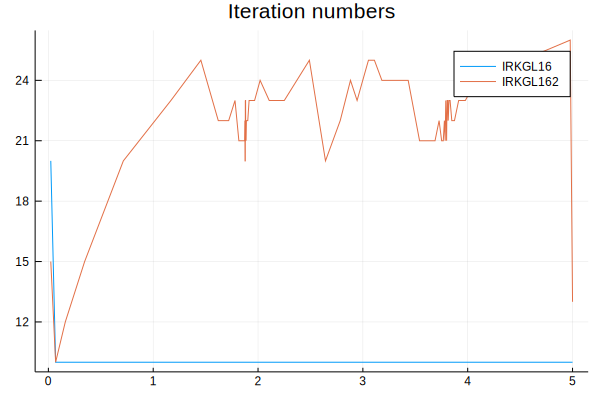

In [19]:
plot(sol1.t[2:end],iter1[2:end], title="Iteration numbers", label="IRKGL16")
plot!(sol2.t[2:end],iter2[2:end],label="IRKGL162")

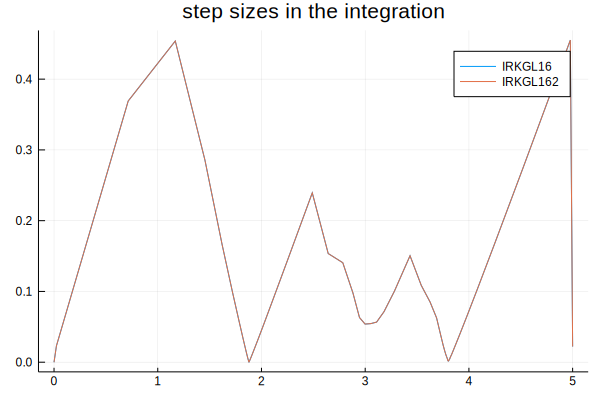

In [20]:
plot(sol1.t,steps1, title="step sizes in the integration", label="IRKGL16")
plot!(sol2.t,steps2,label="IRKGL162")

### Plots

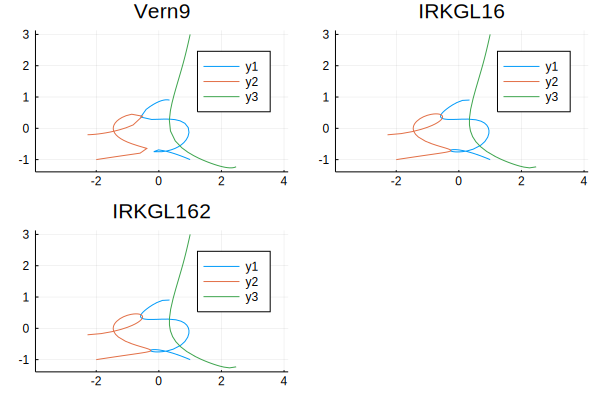

In [25]:
bodylist = ["Body-1", "Body-2", "Body-3"]
ulist0 = sol0.u
tlist0 = sol0.t

pl1 = plot(title="Vern9",aspect_ratio=1)

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist0)
 ylist  = map(u->u[2,2,j], ulist0)
 pl1 = plot!(xlist,ylist) # label = bodylist[j])   
end    


pl2 = plot(title="IRKGL16",aspect_ratio=1)

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist1)
 ylist  = map(u->u[2,2,j], ulist1)
 pl2 = plot!(xlist,ylist) # label = bodylist[j])   
end  


pl3 = plot(title="IRKGL162",aspect_ratio=1)

ulist2 = sol2.u[1:end]
tlist2 = sol2.t[1:end]

for j = 1:3
 xlist  = map(u->u[2,1,j], ulist2)
 ylist  = map(u->u[2,2,j], ulist2)
 pl3 = plot!(xlist,ylist) # label = bodylist[j])   
end  

#plot(pl)
plot(pl1,pl2,pl3, layout=3) 

In [26]:
plot(pl2)
savefig("Burrau.png")

<a href="#top">Back to the top</a>

## Error in energy

In [27]:
setprecision(BigFloat, 256)
u0128, Gm =InitialBurrau(BigFloat)
tspan128=(BigFloat(0.0),BigFloat(T))

(0.0, 5.0)

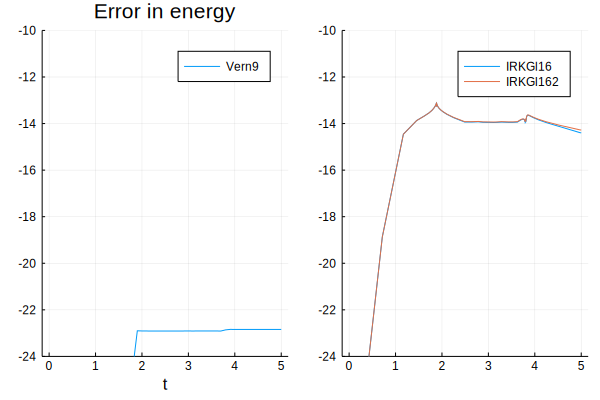

In [28]:
E0=NbodyEnergy(u0128,Gm)
end1=length(steps1)

ulist = sol0.u
tlist = sol0.t
EnergyErrors=[NbodyEnergy(BigFloat.(sol0.u[j]),Gm)/E0-1 for j in 1:length(tlist)]

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]
EnergyErrors1=[NbodyEnergy(BigFloat.(sol1.u[j]),Gm)/E0-1 for j in 1:length(tlist1)]

ulist2 = sol2.u[1:end]
tlist2 = sol2.t[1:end]
EnergyErrors2=[NbodyEnergy(BigFloat.(sol2.u[j]),Gm)/E0-1 for j in 1:length(tlist2)]

ylimit1=-24
ylimit2=-10

p1=plot(tlist[1:end],log10.(abs.(EnergyErrors)),
    ylims=(ylimit1,ylimit2),
   xlabel="t", title="Error in energy", label="Vern9")
p2=plot(tlist1[1:end],log10.(abs.(EnergyErrors1)),
        ylims=(ylimit1,ylimit2),
        label="IRKGl16")
p2=plot!(tlist2[1:end],log10.(abs.(EnergyErrors2)),
        ylims=(ylimit1,ylimit2),
        label="IRKGl162")
plot(p1,p2,layout=2)

In [30]:
(Float32(maximum(abs.(EnergyErrors))),Float32(maximum(abs.(EnergyErrors1))),Float32(maximum(abs.(EnergyErrors2))))

(1.445611948526274623985384149811883707555926576865063955486881349740157008625569e-23, 7.605538618460473418574237191834810340982745391224753524479974483300054724961717e-14, 7.620663331921984028872413508487662457417143724253967846903925981096623236745991e-14)

## Global errror

In [19]:
# IRGL16
apr = appxtrue(sol1,test_sol)
#@show sol1[end]
#@show apr.u[end]
@show apr.errors

apr.errors = Dict(:l∞ => 22.91785175679198640436853504844454144412734622358880462451385455296887753609086,:L2 => 0.3589796791425479359194564236908078626794093234285620825399766782025848374895098,:final => 2.039581675124635773797309180404950615357314527934512567822142777481294236470915e-14,:l2 => 2.510097457280152349245011178323112411429412836544794812220289304989219421515688,:L∞ => 7.952861211197715914774780053535154451798257779818820645988002053201817264526)


Dict{Symbol,BigFloat} with 5 entries:
  :l∞    => 22.9179
  :L2    => 0.35898
  :final => 2.03958e-14
  :l2    => 2.5101
  :L∞    => 7.95286

In [32]:
err1=Float32(norm(sol1.u[end]-sol0.u[end]))
err2=Float32(norm(sol2.u[end]-sol0.u[end]))
(err1,err2)

(1.2603085f-13, 1.3129457f-13)

## Higher Order Algorithms

In [21]:
now()

2020-04-16T09:09:50.252

In [22]:
abstols = 1.0 ./ 10.0 .^ (10:20)
reltols = 1.0 ./ 10.0 .^ (10:20);

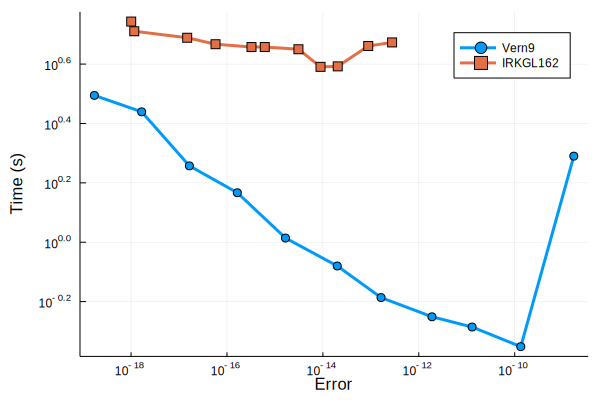

In [23]:
setups = [
#    Dict(:alg=>DP8())
#    Dict(:alg=>Vern8())  
          Dict(:alg=>Vern9())
          Dict(:alg=>IRKGL16())   
          Dict(:alg=>IRKGL162())];
wp = WorkPrecisionSet(prob128,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=1, maxiters=10000000)
plot(wp)

In [24]:
now()

2020-04-16T09:13:41.786